In [11]:
import polars as pl
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from datetime import date
import datetime
from google.colab import drive
import lightgbm as lgb


drive.mount('/content/drive')
year = datetime.date.today().year


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
shapefile_gdf = gpd.read_file("/content/drive/MyDrive/data_ohio/maps/tl_2021_39_bg").to_crs("EPSG:4269")

In [13]:
df_big = pl.read_parquet("/content/drive/MyDrive/data_ohio/SWVF_full.parquet")

In [14]:
df = pl\
    .read_parquet("/content/drive/MyDrive/data_ohio/SWVF_full.parquet")\
    .with_columns(pl.from_epoch(pl.col("date_of_birth")))\
    .with_columns(pl.col("date_of_birth").dt.year())\
    .with_columns(pl.col("date_of_birth").cast(pl.Int64))\
    .with_columns((year - pl.col("date_of_birth")).alias('age'))\
    .with_columns(pl.from_epoch(pl.col("registration_date")))\
    .with_columns(pl.col("registration_date").dt.year())\
    .with_columns(pl.col("registration_date").cast(pl.Int64))\
    .with_columns((year - pl.col("registration_date")).alias('age'))\
    .select(["sos_voter_id", "latitude", "longitude","general_2020", "party_affiliation","age"])\
    .to_pandas()

geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]

geo_df = gpd.GeoDataFrame(df, geometry=geometry)


In [15]:
joined_gdf = gpd.sjoin(geo_df,
                       shapefile_gdf,
                       how="inner",
                       predicate="within")\
                .filter(items=["sos_voter_id",
                               "GEOID",
                               "general_2020",
                               "party_affiliation"])\
                .rename(columns={"GEOID":"block_group_id"})\
                .assign(block_group_id = lambda x: x.block_group_id.astype(int))

df = pl.from_pandas(joined_gdf)

<ipython-input-15-ce4614d0b058>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4269

  joined_gdf = gpd.sjoin(geo_df,


In [21]:
df_features = pl.read_parquet("/content/df_features.parquet")\
                .with_columns([
                    pl.col("block_group_id")\
                      .cast(pl.Int64, strict=False)\
                      .alias("block_group_id")
                ])

df_features = df_features.select(pl.col(pl.NUMERIC_DTYPES))
df_big = pl.read_parquet("/content/drive/MyDrive/data_ohio/SWVF_full.parquet")
df_full = df.join(df_features, how="left", on="block_group_id")

df_full_with_features = df_full.join(df_big, how="left", on="sos_voter_id")

In [22]:
primary = df_full_with_features.select(pl.col("^primary.*$"))

primary_dummies = primary.to_dummies()

df_ml = pl.concat([
    df_full_with_features.drop(primary.columns),
    primary_dummies
], how="horizontal")


NUMERIC_POLARS_DTYPES = [
    pl.Int8, pl.Int16, pl.Int32, pl.Int64,
    pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64,
    pl.Float32, pl.Float64,
]

number_columns = pl.col(NUMERIC_POLARS_DTYPES)



In [23]:
target_party = df_ml['party_affiliation']
# target_TO = df_ml['general_2020']

X_party = df_ml.select(number_columns).drop(['general_2020', 'general_2020_right'])
# X_party = df_ml.select(number_columns)



In [30]:

X_party = X_party.interpolate()

In [39]:
X_party.write_parquet("/content/drive/My Drive/X_party.parquet")
print("successful")

successful


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [42]:
X_sample, _, target_sample, _ = train_test_split(X_party, target_party=="R", test_size=0.9, random_state=42)


In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_sample, target_sample, test_size=0.2, random_state=42)


In [46]:
rf_clf_R = RandomForestClassifier(n_estimators=100, random_state=42)


In [47]:
rf_clf_R.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [48]:
y_pred = rf_clf_R.predict(X_test)

In [49]:
metrics.accuracy_score(y_test,y_pred)

0.998513603185136

In [53]:
import pickle

with open('/content/drive/My Drive/rf_clf_R_model.pkl', 'wb') as file:
    pickle.dump(rf_clf_R, file)


In [2]:
import pickle

with open('/content/drive/My Drive/rf_clf_R_model.pkl', 'rb') as file:
    rf_clf_R = pickle.load(file)


In [19]:
import pandas as pd
X_party = pd.read_parquet("/content/drive/My Drive/X_party.parquet")

In [4]:
republican_scale = rf_clf_R.predict_proba(X_party)[:, 1]

In [5]:
sum(republican_scale>.2)/len(republican_scale)

0.17820203273077975

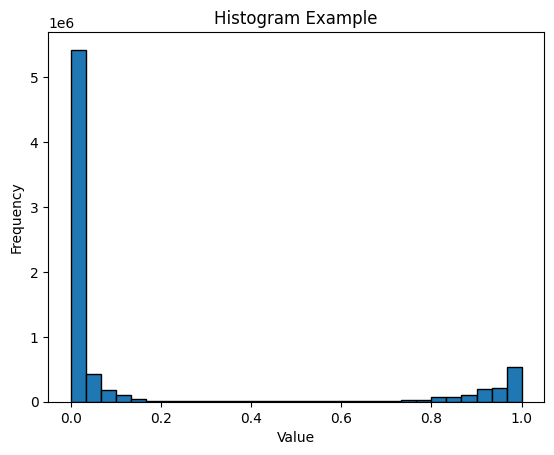

In [6]:
import matplotlib.pyplot as plt
plt.hist(republican_scale, bins=30, edgecolor='k')
plt.title('Histogram Example')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [7]:
R_probs_df = pd.DataFrame(
    list(X_party.sos_voter_id),
    list(republican_scale)
).reset_index()\
 .rename(columns={"index": "R_probs",
                   0:"sos_voter_id"})

R_probs_df.to_parquet("/content/drive/My Drive/R_probs_df.parquet")



zd

In [33]:
X_sample, _, target_sample, _ = train_test_split(X_party, target_party=="D", test_size=0.9, random_state=42)


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_sample, target_sample, test_size=0.2, random_state=42)


In [35]:
rf_clf_D = RandomForestClassifier(n_estimators=100, random_state=42)


In [36]:
rf_clf_D.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [37]:
y_pred = rf_clf_D.predict(X_test)

In [39]:
metrics.accuracy_score(y_test,y_pred)

0.9985467816854678

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_sample, target_sample, test_size=0.2, random_state=42)


In [40]:
import pickle

with open('/content/drive/My Drive/rf_clf_D_model.pkl', 'wb') as file:
    pickle.dump(rf_clf_D, file)


In [5]:
import pickle

with open('/content/drive/My Drive/rf_clf_D_model.pkl', 'rb') as file:
    rf_clf_D = pickle.load(file)


In [1]:
import pandas as pd
X_party = pd.read_parquet("/content/drive/My Drive/X_party.parquet")

In [6]:
democrat_scale = rf_clf_D.predict_proba(X_party)[:, 1]

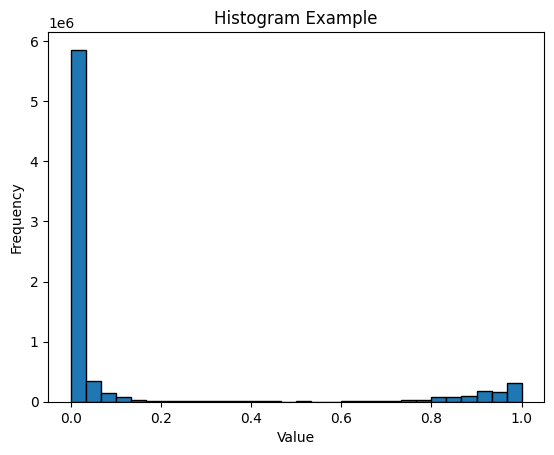

In [7]:
import matplotlib.pyplot as plt
plt.hist(democrat_scale, bins=30, edgecolor='k')
plt.title('Histogram Example')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [8]:
D_probs_df = pd.DataFrame(
    list(X_party.sos_voter_id),
    list(democrat_scale)
).reset_index()\
 .rename(columns={"index": "D_probs",
                   0:"sos_voter_id"})

D_probs_df.to_parquet("/content/drive/My Drive/D_probs_df.parquet")



*
*    
*   
*
*   
*   
*



In [ ]:
null_counts = {col_name: X_to[col_name].is_null().sum() for col_name in X_to.columns}
print("Number of missing values in each column:", null_counts)

Number of missing values in each column: {'sos_voter_id': 0, 'block_group_id': 0, 'COUNTYFP': 0, 'median_income': 0, 'median_income_moe': 0, 'median_earnings': 0, 'median_earnings_moe': 0, 'pop_over_16_laborforce': 0, 'pop_civilian_laborforce': 0, 'pop_civilian_laborforce_employed': 0, 'pop_civilian_laborforce_armedforces': 0, 'percent_employed_total': 0, 'percent_employed_civilian': 0, 'income_below_poverty': 0, 'family_below_poverty': 0, 'family_married_below_poverty': 0, 'percent_family_below_poverty': 0, 'percent_family_married_below_poverty': 0, 'employed_pop': 0, 'employed_management': 0, 'employed_business': 0, 'employed_compsci': 0, 'employed_engineering': 0, 'employed_socialscience': 0, 'employed_socialservice': 0, 'employed_legal': 0, 'employed_education': 0, 'employed_arts': 0, 'employed_healthcare_practitioners': 0, 'employed_health_technologists': 0, 'employed_healthcaresupport': 0, 'employed_protectiveservice': 0, 'employed_firefighting': 0, 'employed_lawenforcement': 0, 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import xgboost as xgb
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
X_to2 = X_to.sample(500000).to_pandas()
target_TO = target_TO.to_pandas()
target_TO2 = target_TO[X_to2.index]

X_train, X_test, y_train, y_test = train_test_split(X_to2, target_TO2, test_size=0.2, random_state=42)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

In [ ]:
import os
import pickle
# Save the file to your Google Drive
with open('/content/drive/My Drive/OH_2024_TO_RF_V2.pkl', 'wb') as f:
    # Assuming 'model' is the object you want to save
    pickle.dump(rf_classifier, f)
    print("successfull")

successfull


In [ ]:
from sklearn import metrics

# Since it's a classification problem, you can also calculate accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

# If you want to interpret the classifier output as probabilities, you can use predict_proba
y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]  # Assuming 1 is the positive class

# Now, you can calculate regression-like metrics for these probabilities
mae = metrics.mean_absolute_error(y_test, y_pred_proba)
print('Mean Absolute Error:', mae)

mse = metrics.mean_squared_error(y_test, y_pred_proba)
print('Mean Squared Error:', mse)

r2 = metrics.r2_score(y_test, y_pred_proba)
print('R-squared:', r2)




In [ ]:
import pickle

with open("/content/OH_2024_TO_RF.pkl", "rb") as file:
  model = pickle.load(file)

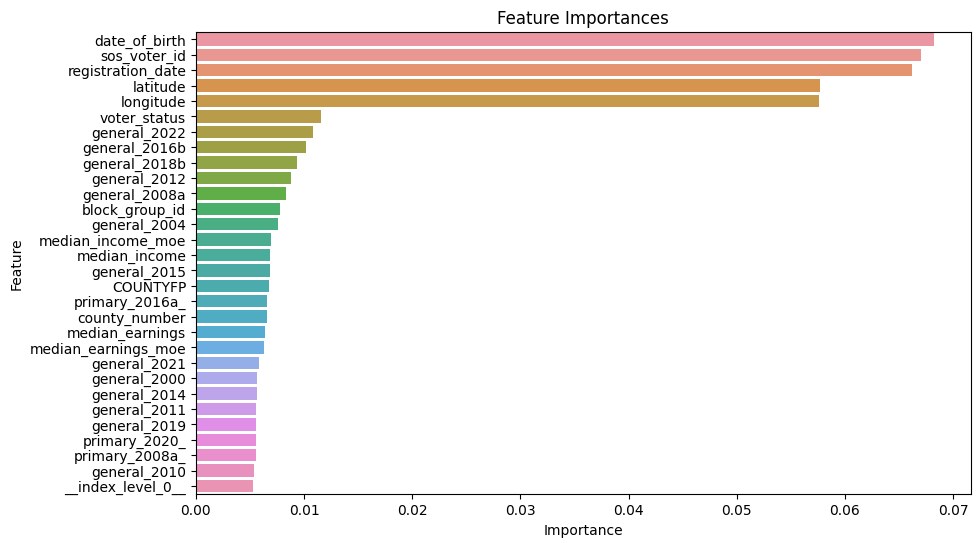

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = rf_classifier.feature_importances_
feature_names = X_train.columns
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False).head(30)
plt.figure(figsize=(10, 6))
sns.barplot(data=importances_df, x='Importance', y='Feature')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [ ]:
importances_df

,Feature,Importance
103,date_of_birth,0.063436
0,sos_voter_id,0.061742
104,registration_date,0.061245
134,latitude,0.053690
135,longitude,0.053345
...,...,...
233,primary_2012_S,0.000000
148,primary_2002_L,0.000000
236,primary_2013a_C,0.000000
244,primary_2013c_,0.000000


import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(importances_df, *['Importance'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(importances_df, *['Importance'], **{})
chart

In [ ]:
import polars as pl
X_to = pl.read_parquet("/content/drive/MyDrive/TO_data.parquet")

In [ ]:
import pickle

with open("/content/drive/MyDrive/OH_2024_TO_RF_V2.pkl", "rb") as file:
  model = pickle.load(file)

In [ ]:
TO_probs = model.predict_proba(X_to)[:, 1]

In [ ]:
TO_probs.sum()

5370944.5299999975

In [ ]:
predictions_df = pl.from_numpy(TO_probs, schema=["VT_prediction"], orient="col")

In [ ]:
predictions_df.head()

VT_prediction
f64
0.95
0.71
0.99
1.0
0.98


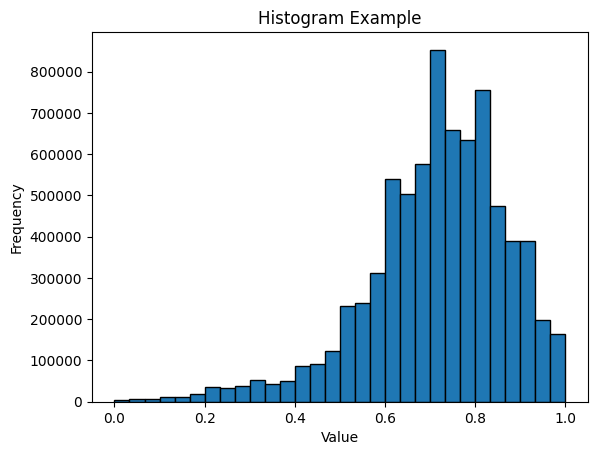

In [ ]:
import matplotlib.pyplot as plt
plt.hist(predictions_df, bins=30, edgecolor='k')
plt.title('Histogram Example')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [ ]:
voterid = X_to.select("sos_voter_id")

VFTO = pl.concat([voterid,predictions_df], how = "horizontal")

In [ ]:
VFTO.head()

sos_voter_id,VT_prediction
i32,f64
16289335,0.95
16289352,0.71
16289539,0.99
16289542,1.0
16289545,0.98


In [ ]:
VFTO.write_parquet("/content/drive/My Drive/OH_VT_Predictions.parquet")
print("successful")

successful


In [ ]:
X_to = df_ml.select(number_columns).drop(['general_2020', 'general_2020_right'])

target_party_R = df_ml['party_affiliation'] == "R"
target_party_D = df_ml['party_affiliation'] == "D"


party_affiliation
bool
true
false
false
true
true
false
true
true
true


In [ ]:
X_to = X_to.interpolate()

null_counts = {col_name: X_to[col_name].is_null().sum() for col_name in X_to.columns}
print("Number of missing values in each column:", null_counts)

Number of missing values in each column: {'sos_voter_id': 0, 'block_group_id': 0, 'COUNTYFP': 0, 'median_income': 0, 'median_income_moe': 0, 'median_earnings': 0, 'median_earnings_moe': 0, 'pop_over_16_laborforce': 0, 'pop_civilian_laborforce': 0, 'pop_civilian_laborforce_employed': 0, 'pop_civilian_laborforce_armedforces': 0, 'percent_employed_total': 0, 'percent_employed_civilian': 0, 'income_below_poverty': 0, 'family_below_poverty': 0, 'family_married_below_poverty': 0, 'percent_family_below_poverty': 0, 'percent_family_married_below_poverty': 0, 'employed_pop': 0, 'employed_management': 0, 'employed_business': 0, 'employed_compsci': 0, 'employed_engineering': 0, 'employed_socialscience': 0, 'employed_socialservice': 0, 'employed_legal': 0, 'employed_education': 0, 'employed_arts': 0, 'employed_healthcare_practitioners': 0, 'employed_health_technologists': 0, 'employed_healthcaresupport': 0, 'employed_protectiveservice': 0, 'employed_firefighting': 0, 'employed_lawenforcement': 0, 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import xgboost as xgb
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Model Republican

In [ ]:
# Assuming X_to and target_TO are aligned and have the same length
combined = X_to.to_pandas()
combined['target'] = target_TO

# Sample combined DataFrame
combined_sample = combined.sample(500000)

# Split back into features and labels
X_to2 = combined_sample.drop(columns='target')
target_TO2 = combined_sample['target']

# Convert to pandas if they are not already (assuming X_to2 is a pandas DataFrame here)
X_train, X_test, y_train, y_test = train_test_split(X_to2, target_TO2, test_size=0.2, random_state=42)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)


In [ ]:
accuracy = metrics.recall_score(y_test, y_pred)
print('Accuracy:', accuracy)


NameError: ignored

Model Democrat

In [ ]:
X_to2 = X_to.sample(500000).to_pandas()
target_party_D = target_party_D.to_pandas()
target_party_D = target_party_D[X_to2.index]

X_train, X_test, y_train, y_test = train_test_split(X_to2, target_party_D, test_size=0.2, random_state=42)

d_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

d_classifier.fit(X_train, y_train)

y_pred = d_classifier.predict(X_test)